# Analyse exploratoire des données

Ce notebook sert à l'analyse exploratoire des données d'enrichissement pour toute la Suisse. Nous ne ferons ici que des analyses de bases, n'ayant pas encore ajouté les données de présences. Cela nous permettra de nous rendre compte des données utilisées ainsi que de leurs répartitions.

In [23]:
# Import pour ce notebook
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import chi2_contingency

## Import des données

Avant de commencer, il nous faut importer notre jeu de données

In [24]:
file_path = '../../data/processed/processed_enhanced_swiss_data.csv'

df = pd.read_csv(file_path)
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))
gdf.set_crs(epsg=2056, inplace=True)
gdf.set_index("idx", inplace=True)

gdf.head()

,geometry,Altitude,NaturalHabitat,SoilType,WaterRetention,NutrientContent,WaterPermeability,Temperature
idx,,,,,,,,
35,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",363.5148,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.2
36,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",358.9348,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.2
261,"POLYGON ((2486071.58 1109261.72, 2487071.58 11...",415.6684,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0,5.3
262,"POLYGON ((2486071.58 1110261.72, 2487071.58 11...",368.5936,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0,5.3
263,"POLYGON ((2486071.58 1111261.72, 2487071.58 11...",352.9472,82.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.3


Afin de pouvoir afficher de manière plus claire les valeur catégorielles dans les différents graphiques, nous allons également importer la table de traduction créée à cet effet.

In [25]:
tranlation_path = '../../data/processed/translation_table.csv'

data = pd.read_csv(tranlation_path)
translation = pd.DataFrame(data)
translation.head()

,Unnamed: 0,Feature,Value,Category
0,0,NaturalHabitat,11,1.1 Eaux calmes
1,1,NaturalHabitat,12,1.2 Eaux courantes
2,2,NaturalHabitat,13,1.3 Sources et suintements
3,3,NaturalHabitat,14,1.4 Eaux souterraines
4,4,NaturalHabitat,20,2.0 Rives artificielles


Pour simplifier l'utilisation de la table lors de l'affichage des histogramme, la fonction suivante a été créée.

In [26]:
def bar_plot_with_categories(gdf, translation, feature_name):
    # Filtrer la table de traduction pour la caractéristique spécifiée
    feature_translation = translation[translation['Feature'] == feature_name]
    
    # Fusionner les données principales avec la table de traduction
    gdf_merged = gdf.merge(feature_translation, how='left', left_on=feature_name, right_on='Value')
    
    # Compter les occurrences par catégorie
    counts = gdf_merged['Category'].value_counts()
    
    # Ordonner les catégories par leur valeur d'origine
    ordered_categories = feature_translation.sort_values(by='Value')['Category']
    counts = counts.reindex(ordered_categories, fill_value=0)
    
    # Tracer l'histogramme
    plt.bar(counts.index, counts.values)
    plt.xlabel('Catégories')
    plt.ylabel('Fréquence')
    plt.title(f'Distribution des catégories de {feature_name}')
    plt.xticks(rotation=45)
    plt.show()

## Aptitude des sols

Pour simplifier l'affichage des cartes de cette section, une fonction a été créée pour cela

In [5]:
def create_categorical_map(dataframe, translation, column_name, with_names=True):
    fig, ax = plt.subplots()

    if with_names:
        # Filtrer la table de traduction pour la caractéristique spécifiée
        feature_translation = translation[translation['Feature'] == column_name]
        
        # Fusionner les données principales avec la table de traduction
        dataframe = dataframe.merge(feature_translation, how='left', left_on=column_name, right_on='Value')

        # Obtenir les catégories uniques
        categories = feature_translation.sort_values(by='Value')['Category']
    else:
        categories = sorted(dataframe[column_name].dropna().unique())
    
    # Définir une colormap discrète
    colormap = plt.colormaps.get_cmap('tab20')
    color_dict = {category: colormap(i) for i, category in enumerate(categories)}

    
    # Ajouter chaque polygone à l'axe avec la couleur basée sur la colonne
    for idx, row in dataframe.iterrows():
        polygon = row['geometry']
        value = (row['Category'] if with_names else row[column_name])

        # Ignorer les valeurs NaN
        if pd.isna(value):
            continue

        color = color_dict[value]
        x, y = polygon.exterior.xy
        ax.fill(x, y, color=color)

    # Ajouter une légende
    handles = [plt.Line2D([0, 1], [0, 0], color=color_dict[category], lw=4) for category in categories]
    ax.legend(handles, categories, title=column_name, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Configurer l'affichage
    ax.set_title(f'Cellules colorées par "{column_name}"')
    ax.set_aspect('equal', adjustable='box')

    # Afficher la figure
    plt.show()

### Type de sol

Les différents types de sols ont été représentés sur la carte ci-dessous. Leur nombre rend malheureusement la carte difficile à lire mais permet de se rendre compte comment ils sont répartis sur le territoire suisse : quelques zones dont le sol est inconnu, quelques grandes zones d'un unique type de sol et beaucoup d'endroits avec un mélange.

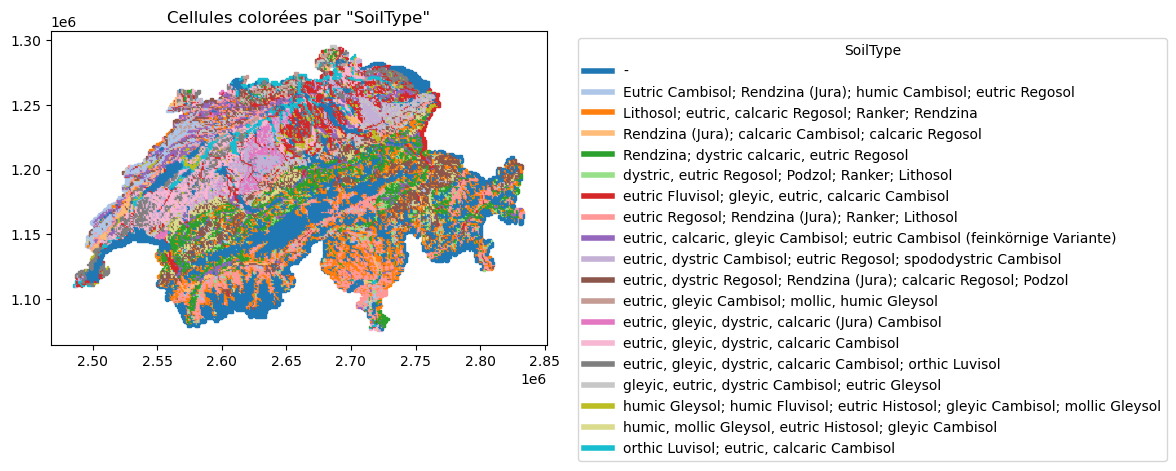

In [6]:
create_categorical_map(gdf, translation, 'SoilType', False)

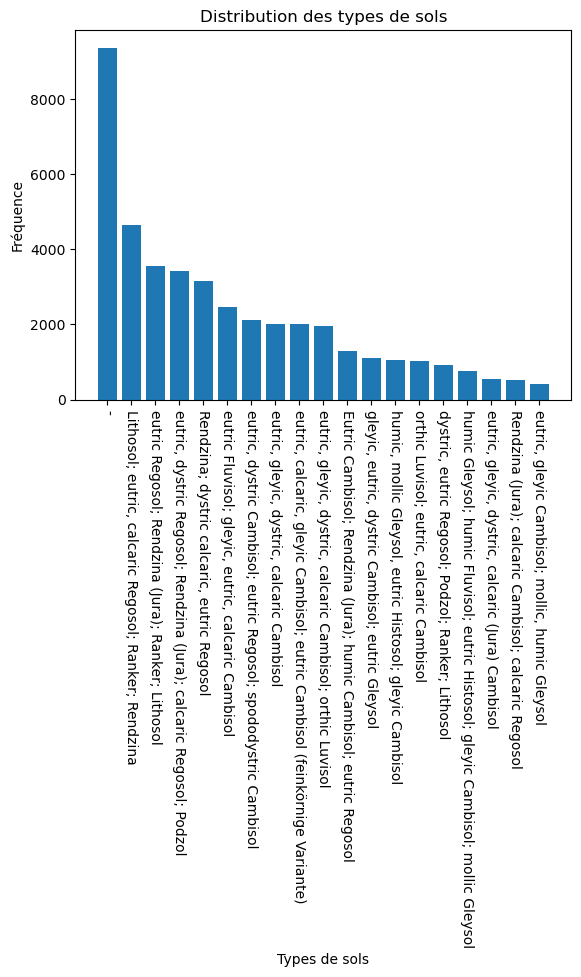

In [7]:
# Compter les occurrences par catégorie uniquement pour les valeurs existantes
counts = gdf['SoilType'].value_counts()

# Tracer l'histogramme
plt.bar(counts.index, counts.values)
plt.xlabel('Types de sols')
plt.ylabel('Fréquence')
plt.title('Distribution des types de sols')
plt.xticks(rotation=-90)
plt.show()

### Capacité de rétention hydrique

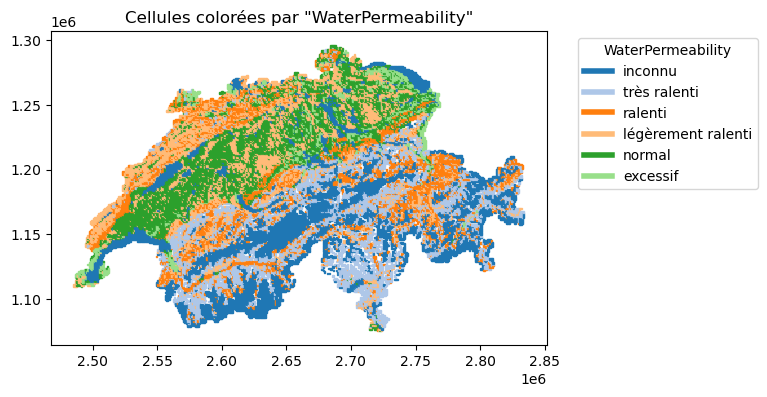

In [8]:
create_categorical_map(gdf, translation, 'WaterPermeability')

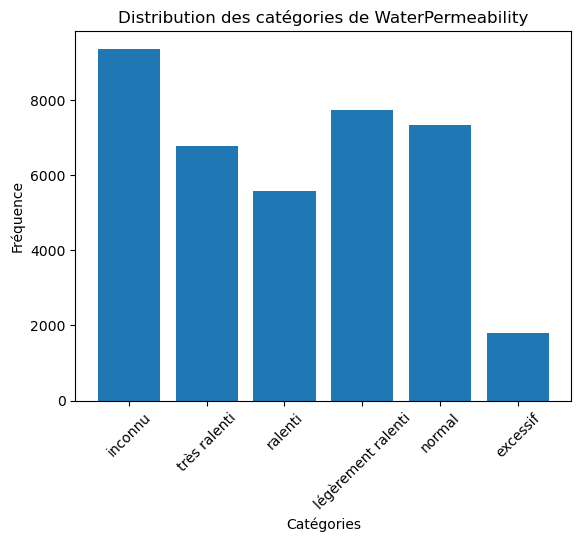

In [9]:
bar_plot_with_categories(gdf, translation, 'WaterPermeability')

### Capacité de rétention en substances nutritives

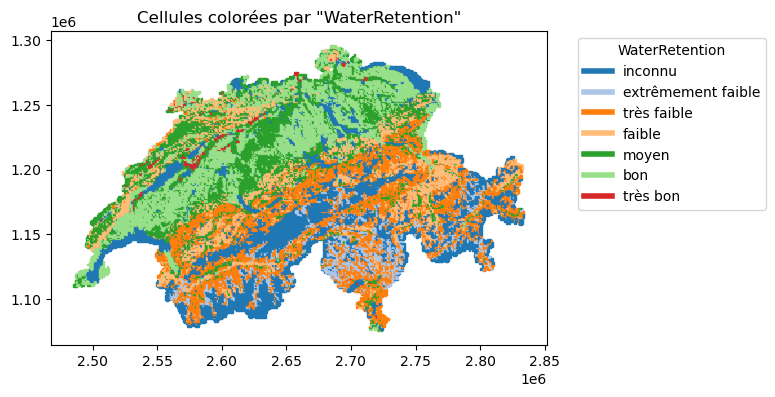

In [10]:
create_categorical_map(gdf, translation, 'WaterRetention')

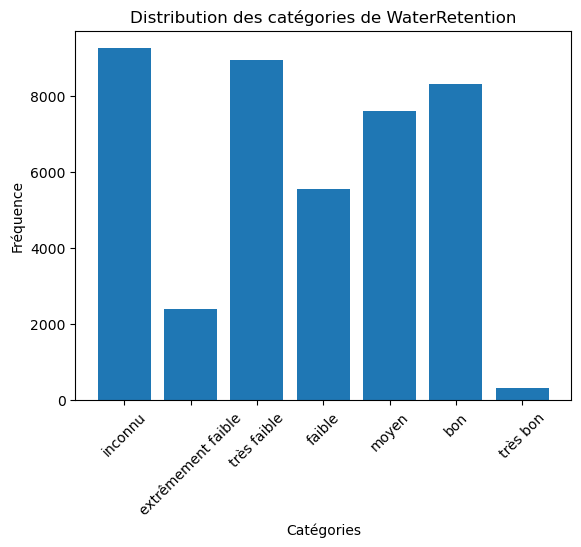

In [11]:
bar_plot_with_categories(gdf, translation, 'WaterRetention')

### Perméabilité

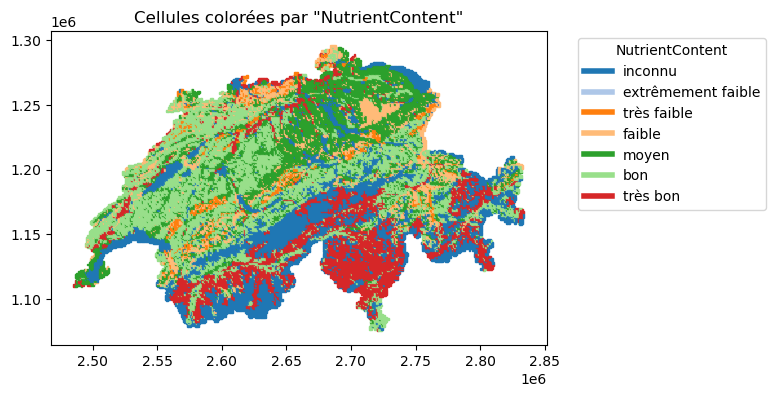

In [12]:
create_categorical_map(gdf, translation, 'NutrientContent')

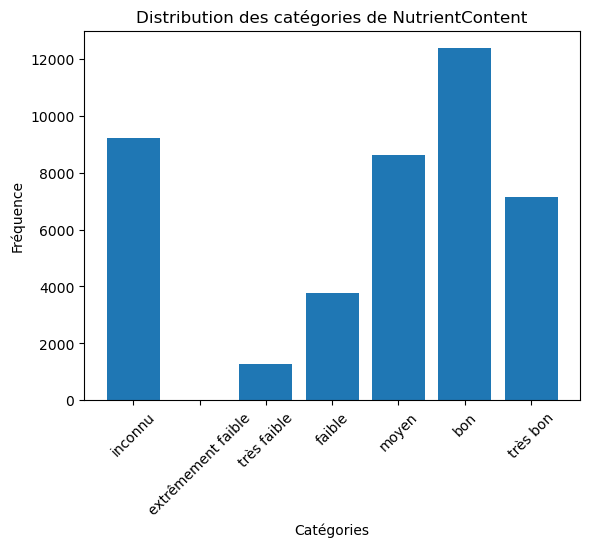

In [13]:
bar_plot_with_categories(gdf, translation, 'NutrientContent')

## Milieux naturels

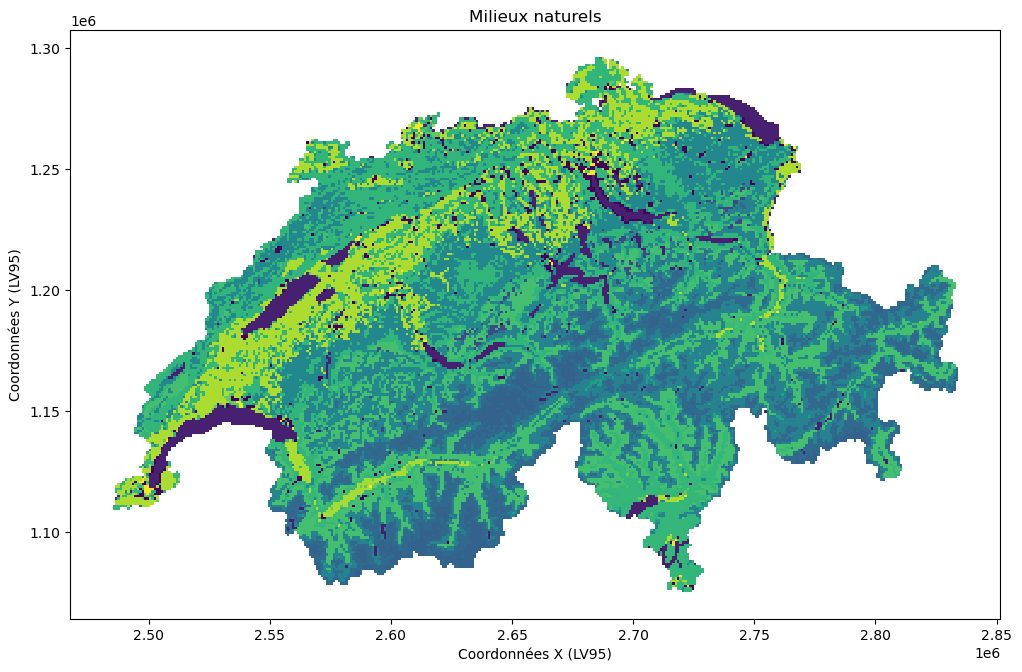

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf.plot(column='NaturalHabitat', ax=ax, cmap='viridis')

plt.title('Milieux naturels')
plt.xlabel('Coordonnées X (LV95)')
plt.ylabel('Coordonnées Y (LV95)')
plt.show()

Remarque : Au vue du grand nombre de classes présentes pour cet attribut, nous avons décidé de ne pas utiliser de couleurs distinctes entre chacunes d'elles mais d'utiliser une palette continue. De cette manière, les différentes zones sont beaucoup plus lisbles et chaque zone a sa propre couleur, bien que celles-ci puissent être proches les unes des autres.

In [28]:
# Filtrer la table de traduction pour TypoCH_NUM
feature_translation = translation[translation['Feature'] == 'NaturalHabitat']

# Fusionner les données principales avec la table de traduction
df_merged = gdf.merge(feature_translation, how='left', left_on='NaturalHabitat', right_on='Value')

# Compter les occurrences par catégorie uniquement pour les valeurs existantes
counts = df_merged['Category'].value_counts()

# Trier les catégories par leur valeur numérique d'origine
existing_categories = feature_translation[feature_translation['Category'].isin(counts.index)]
ordered_categories = existing_categories.sort_values(by='Value')['Category']

0                                       1.1 Eaux calmes
1                                    1.2 Eaux courantes
5                           2.1 Rivages avec végétation
6                                        2.2 Bas-marais
7                                  2.3 Prairies humides
8                                  2.4 Tourbière bomées
10                                  3.1 Glaciers, névés
11                            3.2 Alluvions et moraines
12                                          3.3 Eboulis
13                                 3.4 Parois rocheuses
15                 4.0 Gazons et prairies artificielles
16                       4.1 Dalles rocheuses et lapiez
17                     4.2 Pelouses sèches thermophiles
18         4.3 Pelouses et pâturages maigres d'altitude
19                                   4.4 Combes à neige
20                                 4.5 Prairies grasses
23               5.2 Mégaphorbiaies, coupes forestières
24    5.3 Formations buissonnantes (manteau, fou

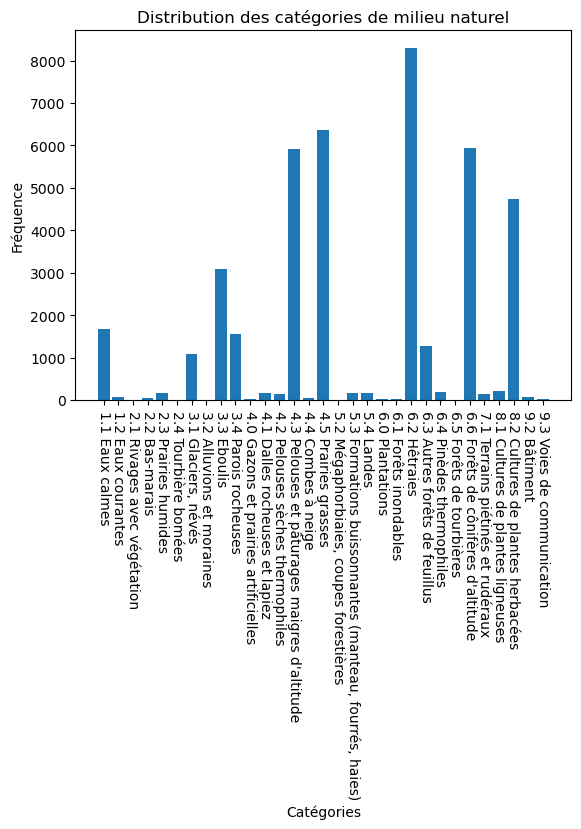

In [16]:
# Réindexer les comptes pour conserver l'ordre des catégories existantes
counts = counts.reindex(ordered_categories, fill_value=0)

# Tracer l'histogramme
plt.bar(counts.index, counts.values)
plt.xlabel('Catégories')
plt.ylabel('Fréquence')
plt.title(f'Distribution des catégories de milieu naturel')
plt.xticks(rotation=-90)
plt.show()

## Altitude

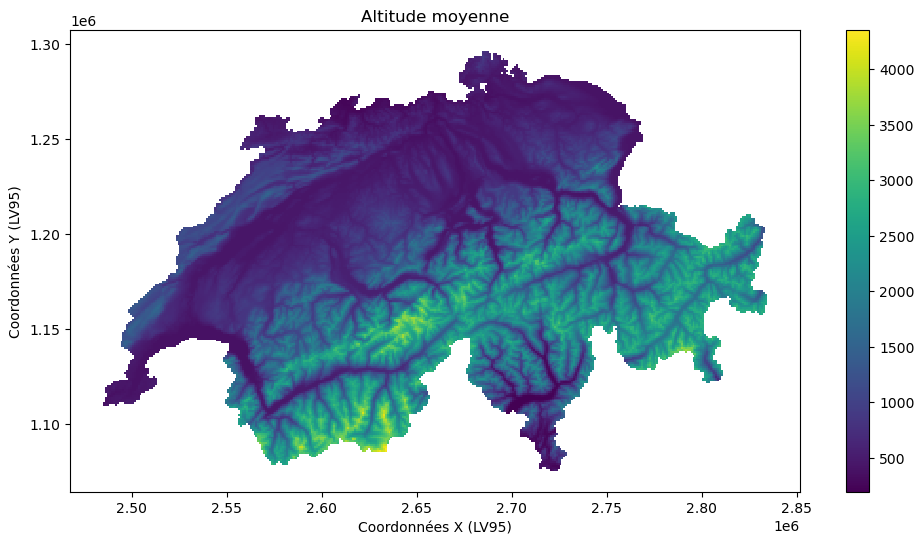

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf.plot(column='Altitude', ax=ax, cmap='viridis', legend=True)

plt.title('Altitude moyenne')
plt.xlabel('Coordonnées X (LV95)')
plt.ylabel('Coordonnées Y (LV95)')
plt.show()

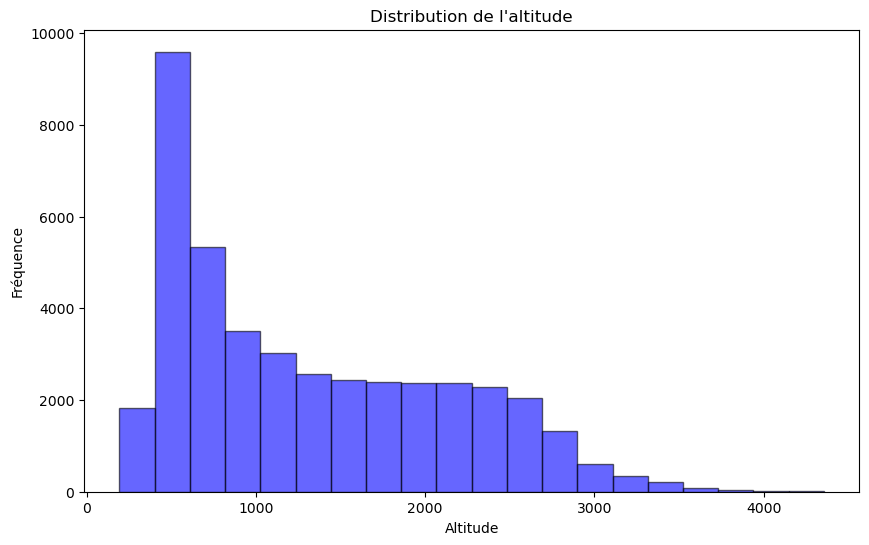

In [18]:
# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(df['Altitude'], bins=20, color='blue', alpha=0.6, edgecolor='black')

# Ajout des titres et des étiquettes
plt.title('Distribution de l\'altitude')
plt.xlabel('Altitude')
plt.ylabel('Fréquence')

# Affichage
plt.show()

## Température

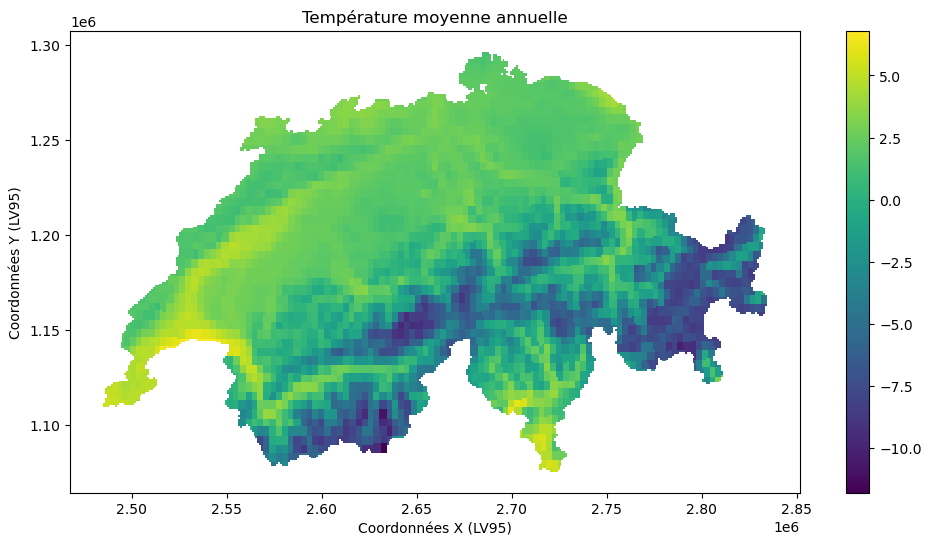

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf.plot(column='Temperature', ax=ax, cmap='viridis', legend=True)

plt.title('Température moyenne annuelle')
plt.xlabel('Coordonnées X (LV95)')
plt.ylabel('Coordonnées Y (LV95)')
plt.show()

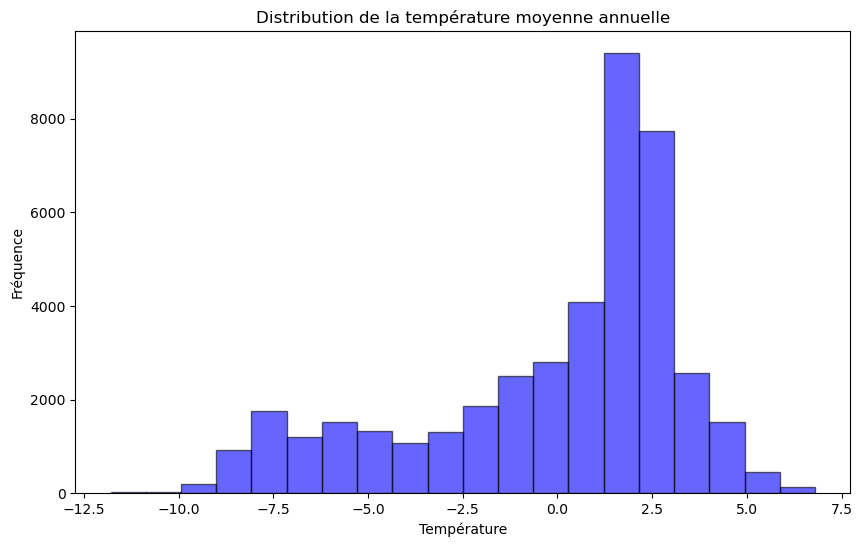

In [20]:
# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(df['Temperature'], bins=20, color='blue', alpha=0.6, edgecolor='black')

# Ajout des titres et des étiquettes
plt.title('Distribution de la température moyenne annuelle')
plt.xlabel('Température')
plt.ylabel('Fréquence')

# Affichage
plt.show()

## Autres visualisations pertinentes

### Matrice de corrélation pour les aptitudes du sol

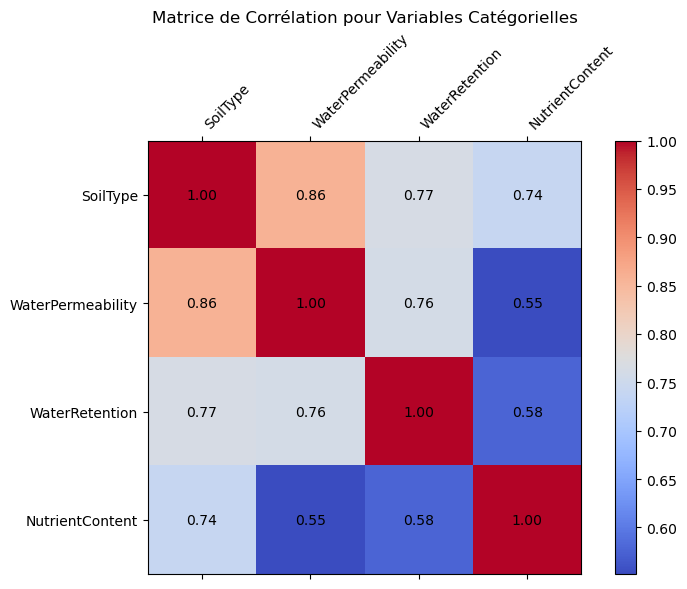

In [21]:
# Colonnes catégorielles
columns = ['SoilType', 'WaterPermeability', 'WaterRetention', 'NutrientContent']

# Calcul de la matrice de corrélation (V de Cramér)
n_cols = len(columns)
correlation_matrix = np.zeros((n_cols, n_cols))

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        # Créer une table de contingence
        contingency_table = pd.crosstab(gdf[col1], gdf[col2])
        chi2, _, _, _ = chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        correlation_matrix[i, j] = np.sqrt(chi2 / (n * min_dim))

# Visualisation de la matrice avec matplotlib
fig, ax = plt.subplots(figsize=(8, 6))

# Affichage de la matrice avec une colormap
cax = ax.matshow(correlation_matrix, cmap="coolwarm")

# Ajouter des ticks et labels
ax.set_xticks(np.arange(n_cols))
ax.set_yticks(np.arange(n_cols))
ax.set_xticklabels(columns, rotation=45, ha='left')
ax.set_yticklabels(columns)

# Ajouter les valeurs dans chaque case
for i in range(n_cols):
    for j in range(n_cols):
        ax.text(j, i, f'{correlation_matrix[i, j]:.2f}', va='center', ha='center', color='black')

# Ajouter une barre de couleur
fig.colorbar(cax)

# Configurer l'affichage
plt.title("Matrice de Corrélation pour Variables Catégorielles")
plt.tight_layout()
plt.show()

### Température en fonction de l'altitude

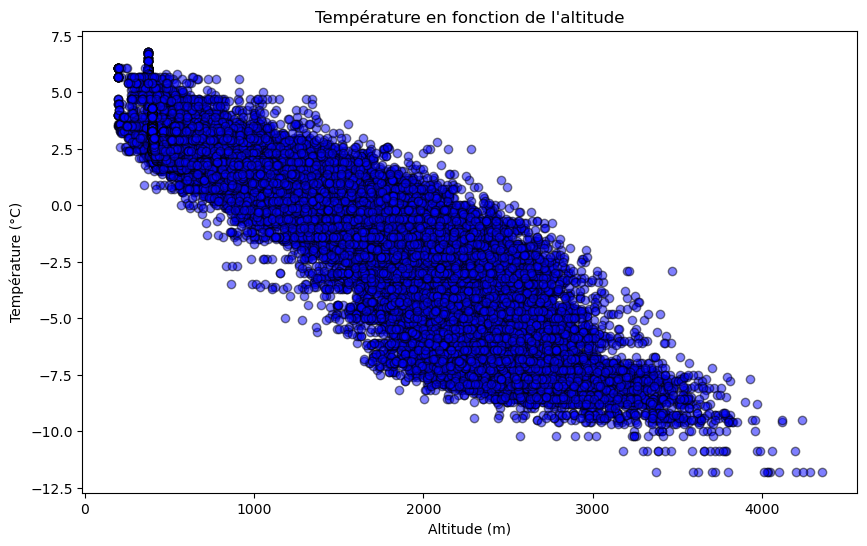

In [22]:
# Création du graphique
plt.figure(figsize=(10, 6))
plt.scatter(df['Altitude'], df['Temperature'], color='blue', alpha=0.5, edgecolor='black')

# Ajout des titres et des étiquettes
plt.title('Température en fonction de l\'altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Température (°C)')

# Affichage
plt.show()